# AIDApy - Notebooks for School

## Aidapy Installation on Google Colab

In order ti run all the notebooks and reproduce the results, the first step is to install the ***aidapy*** Python Package. There are several ways to accomplish that. Tha most efficient and easy way to do that is by using GitLab clone.

In [1]:
%rm -rf aidapy
!git clone https://gitlab.com/aidaspace/aidapy.git aidapy
%cd aidapy
!git pull --all
!git checkout notebooks_merge_dev
!pip install -e .[ml]
!pip uninstall -y heliopy
!pip install heliopy==0.15.0

Cloning into 'aidapy'...
remote: Enumerating objects: 8707, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 8707 (delta 24), reused 21 (delta 21), pack-reused 8654
Receiving objects: 100% (8707/8707), 250.72 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (5520/5520), done.
/content/aidapy
Fetching origin
Already up to date.
Branch 'notebooks_merge_dev' set up to track remote branch 'notebooks_merge_dev' from 'origin'.
Switched to a new branch 'notebooks_merge_dev'
Obtaining file:///content/aidapy
     |████████████████████████████████| 6.0 MB 6.7 MB/s 
     |████████████████████████████████| 83 kB 1.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 929 kB 38.3 MB/s 
     |████████████████████████████████| 308 kB 45.1 MB/s 
     |████████████████████████████████| 631 kB 14.8 MB/s 
     |███████████

In [2]:
# Test the installation of AidaPy package
import aidapy

Creating download directory /root/heliopy/data


# DST Index using Maching Learning

## DST Index - Training the LSTM Neural Network using AIDApy ML Functionalities

In [3]:
import os
import os.path as osp
from torch.utils.data import dataloader
import cv2
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

from aidapy.ml.metrics import Metrics
from aidapy.ml.loss import Loss
from aidapy.ml.data.data import Data
from aidapy.ml.models.model import Model
from aidapy.ml.optim.optim import make_optimizer
from aidapy.ml.utils.ts2plot import ts2plot2im
from aidapy.ml.postprocess import *
from aidapy.ml.utils.logger import Logger

In [4]:
## The directory that has the results of all the use cases
expdir = "Experiments"

## The directory that has the result of a specific use case.
expname = "DST_notebook"
total_dir = osp.join(expdir, expname)

## Create the directories for the results
os.makedirs(total_dir, exist_ok=True)

## In the checkpoints we save the model weights
os.makedirs(total_dir + "/checkpoints", exist_ok=True)

## In the Results we save the training/testing results.
os.makedirs(total_dir + "/Results", exist_ok=True)

# Init Logger for Saving/Printing Messages and Results
log = Logger(experiment_dir=expdir,experiment_name=expname)

In [5]:
# Create a dataloader class to load the dataset. In this case we use the coronalholes dataloader

# This variable can be either "memory" if we want to load a dataset from memory
# or "download" if we want to download a dataset. 
data_mode = "download"
# How to split the dataset in train-validation set.
split = "80-20"
# Random seed for reproducible results
seed=5

data_vars = {'mission': 'omni', 'datetime': ['2011-01-14 00:00:00', '2016-12-31 23:00:00'],
            'settings': {'prod': ['all']}, 'features': ['DST', 'BZ_GSM', 'IMF']}

transform = {'input_feats': ['DST', 'BZ_GSM', 'IMF'], 
            'target_feats': ['DST'], 'horizon': 1, 'window': 6, 'data_mixin': 'LSTM_Format'}
gpu = True

data = Data(get_data_mode=data_mode, transform=transform, get_train_mode=True, get_train_dbs=['Aidapy_OmniWeb'], 
                get_batch_size_val=200, gpu_use=gpu, get_mode='train', 
                data_Vars=data_vars, split=split, get_batch_size=200, random_seed=seed, log=log)

train_data = data.loader_train
test_data = data.loader_test

Dataset (Train): Aidapy_OmniWeb


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/heliopy/data/util.py:837: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[df_key] = data


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

torch.Size([200, 6, 3])
(200, 1, 1)
     Truth
0    -19.0
1     -3.0
2    -10.0
3      0.0
4     19.0
..     ...
195  -29.0
196   -3.0
197  -10.0
198  -13.0
199  -13.0

[200 rows x 1 columns]


Text(0, 0.5, 'Values')

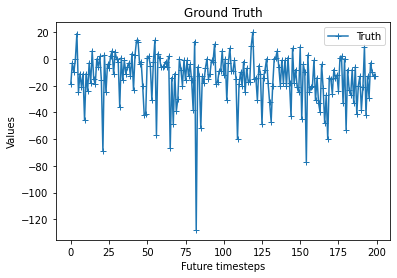

In [6]:
for i, (image, mask, _) in enumerate(train_data):
    image = image.squeeze(1)
    print(image.shape)
    image = image[:, 4, 1]
    mask = mask.cpu().detach().numpy()
    print(mask.shape)
    break

mask = mask.squeeze()
data_frame = pd.DataFrame({ 'Truth': mask})
print (data_frame)
figure = data_frame.plot(style=['+-', 'o-'], 
title='Ground Truth')
figure.set_xlabel("Future timesteps")
figure.set_ylabel("Values")

In [7]:
# The model type to use in your use case. Here we use LSTM.
model = 'lstm'  # or  lstm

# Number of inpuits in the LSTM
model_input = 3
# Number of outputs in the LSTM
model_output = 1
# The depth of the LSTM
hidden_size = 10
# A list that contains the model parameters
model_params = [model_input, model_output, hidden_size]


# If true, we use gpu for training, else cpu
gpu = True
mode= 'train'
check_save_all = True
model = Model(model_params=model_params, gpu_use=gpu, expdir=expdir, 
                expName=expname, model_type=model, mode=mode, check_save_all=check_save_all)

Making model...


In [8]:
# Create the metrics using the Metrics class from aidapy
# A list with the metrics to use in your use case. 
# Check aidapy.ml.metrics.metric_func for the supported
# metrics in aidapy
get_metrics = ['RMSE', 'RSquared']
    
# Create the metrics
metrics = Metrics(get_metrics_split=get_metrics, gpu_use=gpu, log=log)

Preparing Metrics function(s)


In [9]:
# Create the loss functions using the Loss class from aidapy

# A list with all the loss functions for your use case. Check aidapy.ml.loss.loss_func for the supported
# loss functions in aidapy
lossF = ["1*MSE"]
# Print the total loss in every get_print iterations
get_print =10
    
# Create the loss functions
loss = Loss(get_print_every=get_print, get_loss_split=lossF, gpu_use=gpu, log=log)

Preparing loss function:
1.000 * MSE


In [10]:
# Create an optimizer using the make_optimizer class from aidapy. 
optimizer = make_optimizer(model, LR=3e-4, weight_decay=5e-5, getoptim='RMSprop',
                                momentum=0.8, betas=[0.9, 0.999], epsilon=1e-8, 
                                decay_split=[90, 160], gamma=0.1)

In [11]:
def visualize(input, target, pred, savedir):
    img = ts2plot2im(target.cpu().detach().numpy(), pred)
    cv2.imwrite(savedir, img.astype('uint8'))

In [12]:
def train(model, data, loss, gpu, optimizer, epochs, train_iter):
    r"""Handles the training process 
        """
    torch.set_grad_enabled(True)

    loss.step()
    epoch = optimizer.get_last_epoch() + 1
    model.train()

    device = torch.device('cpu' if not gpu
                                   else 'cuda')  
    post_process = PostProcessor('for_1cls')

    for batch, (input, target, _) in enumerate(data):
        input = input.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        # Fit the input to the model
        output = model(input)
        # Post process the model output
        output = post_process(output, train=True)
        # Calculate the losses
        loss_func = loss.forward(output.to(device), target, train_iter)
        loss_func.backward()
        optimizer.step()
        train_iter += 1
        
        
    optimizer.schedule()
    return train_iter

In [13]:
def test(model, data, metrics, gpu, total_dir, epoch, tot_epoch):
    r"""Handles evaluation process (metrics calculation, visualizations and 
           keeping checkpoints).
        """

    device = torch.device('cpu' if not gpu
                                   else 'cuda')  
    torch.set_grad_enabled(False)
    model.eval()
    post_process = PostProcessor('for_1cls')
    for _, d in enumerate(data):
    # Iterate through the dataset
        total_d = len(d)
        metrics.number_of_samples(total_d)
        for i, (input, target, denorm_input) in \
                                    enumerate(d):
            # Create the full path to save the results
            savepath = osp.join(total_dir, 'Results', \
                                    '%0.4d.png' % i)
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            # post process function to use 
            output, out_vis = post_process(output, train=False)
            # Calculate the metrics from the output
            metrics.forward(output.to(device), target)
            #visualize(denorm_input, out_vis, target)
    metrics.get_ave_score(epoch) 
    torch.set_grad_enabled(True) 
    return denorm_input, out_vis, target 

In [14]:
def visualize(input, target, pred):
    img = ts2plot2im(target, pred)
    return img

In [15]:
epochs = 5
iter = 0
for epoch in range(epochs):
    iter = train(model, train_data, loss, gpu, optimizer,epochs, iter)
    denorm_input, out_vis, target= test(model, test_data, metrics, gpu, total_dir, epoch, epochs)

    model.save(epoch, "model_")

Total Loss in iter 0                 is 452.6077
Total Loss in iter 10                 is 339.5693
Total Loss in iter 20                 is 387.1898
Total Loss in iter 30                 is 306.5598
Total Loss in iter 40                 is 333.7052
Total Loss in iter 50                 is 180.6428
Total Loss in iter 60                 is 152.8386
Total Loss in iter 70                 is 167.8450
Total Loss in iter 80                 is 130.6070
Total Loss in iter 90                 is 183.9533
Total Loss in iter 100                 is 259.2620
Total Loss in iter 110                 is 87.1943
Total Loss in iter 120                 is 87.4695
Total Loss in iter 130                 is 165.9345
Total Loss in iter 140                 is 89.3648
Total Loss in iter 150                 is 183.6555
Total Loss in iter 160                 is 72.4504
Total Loss in iter 170                 is 166.9793
Total Loss in iter 180                 is 120.8922
Total Loss in iter 190                 is 316.

    Pred      Truth
0   -6.0  -7.256966
1   -6.0  -6.478989
2   -6.0  -6.674510
3   -7.0  -7.279160
4   -8.0  -8.059319
5   -6.0  -8.327583
6   -3.0  -5.659853
7   -3.0  -5.600262
8   -4.0  -5.767347
9   -4.0  -6.943178
10  -2.0  -5.462152
11  -4.0  -3.866148
12  -8.0  -9.265773
13 -12.0  -9.118057
14 -12.0  -9.894418
15  -9.0  -8.082242
16  -8.0  -7.730163
17  -4.0  -8.302636
18  -2.0  -3.798499
19  -3.0  -6.509328
20   0.0  -5.370712
21   1.0  -3.324303
22   2.0  -4.753747
23  -1.0  -4.077402
24  -1.0  -6.859421
25   3.0  -3.941489
26   4.0  -2.958501
27   3.0  -3.710282
28   1.0  -5.237638
29   2.0  -5.936788
30 -12.0  -7.663522
31 -21.0 -10.871768
32 -29.0 -22.160217
33 -24.0 -11.056770
34 -23.0 -17.099577
35 -18.0 -10.047544
36 -16.0 -14.471699
37 -16.0  -8.443280
38 -19.0 -11.734447
39 -25.0 -17.380053
40 -24.0 -13.769963
41 -13.0 -12.073178


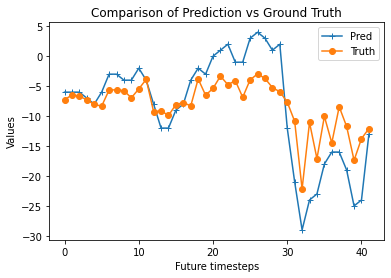

In [16]:
img = visualize(denorm_input.detach().cpu(), out_vis, target.detach().cpu())

## DST Index Use Case - Simple Inference

In [ ]:
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import h5py

from aidapy import load_data
from aidapy.ml.data.common.common import (controlled_train_test_split, split_data,
                            extract_data, preprocess_data, format_to_lstm_input)
from aidapy.ml.data.common.utils import numpy_to_dataloader, run_model, extract_continuous_intervals, reformat_dtw_res

from aidapy.ml.models.lstm import LSTMnn

from aidapy.ml.visualization.dst_vis import plot_set_of_storms
from aidapy.ml.metrics.dtw import dtw_measure

%matplotlib notebook

In [ ]:
## The directory that has the results of all the use cases
expdir = "Experiments"

## The directory that has the result of a specific use case.
expname = "DST_index_Test"
total_dir = osp.join(expdir, expname)

## Create the directories for the results
os.makedirs(total_dir, exist_ok=True)

## In the Results we save the training/testing results.
os.makedirs(total_dir + "/Results", exist_ok=True)

In [ ]:
start_time = datetime(1999, 1, 14, 0, 0, 0)
end_time = datetime(2003, 1, 1, 0, 0, 0)
settings = {'prod': ['all']}

output = 'DST'
time_forward = 1
time_back = 6

omni_data = load_data(mission='omni', start_time=start_time, end_time=end_time, **settings)

features = ['DST', 'BZ_GSM', 'IMF']
df = pd.DataFrame(omni_data['all1'].values, index = omni_data['all1'].coords['time1'].values, columns = omni_data['all1'].coords['products'].values)
df['Delta_Dst'] = df['DST'].diff()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
train, test = controlled_train_test_split(df)
train, valid = split_data(train, 0.2, 'M')
train_in, train_out = extract_data(train, features, output)
valid_in, valid_out = extract_data(valid, features, output)
test_in, test_out = extract_data(test, features, output)

tr_in, sclr = preprocess_data(train_in)
val_in, _ = preprocess_data(valid_in, sclr)
t_in, _ = preprocess_data(test_in, sclr)

train_in, train_out, _ = format_to_lstm_input(tr_in, train_out, time_back, time_forward)
valid_in, valid_out, _ = format_to_lstm_input(val_in, valid_out, time_back, time_forward)
test_in, test_out, lookup = format_to_lstm_input(t_in, test_out, time_back, time_forward)

In [ ]:
def get_storm_dates(stormname='storms_1981_2016.csv'):
    return pd.read_csv(stormname, index_col=0, dtype={'date1': str, 'date2': str},
                       parse_dates=['date1', 'date2'])

def get_storms(data, storm_dates):
    '''Check which storms lie in the given dataset
    Input:
        data: dataset with dates
        storm_dates: list of known storm occurences
    Output:
        measured features during the storm
        storm-dates that lie in data
    '''
    rs = []
    valid_storms = []
    for (_, dates) in storm_dates.iterrows():
        ss = data.loc[dates[0]:dates[1]]
        if ss.shape[0] != 0:
            rs.append(ss)
            valid_storms.append((dates[0].strftime('%Y-%m-%d'), dates[1].strftime('%Y-%m-%d')))
    print('Number of storms in dataset: {}'.format(len(valid_storms)))
    return pd.concat(rs), np.array(valid_storms)

In [ ]:
stormdates = "notebooks_aida/06_dst_xai/storms_1981_2016.csv"
storm_dates = get_storm_dates(stormname=stormdates)
test_storms, test_storm_dates = get_storms(test, storm_dates)
test_storm_dates = test_storm_dates.astype('datetime64')

Number of storms in dataset: 8


In [ ]:
print(test_storm_dates)

[['1999-04-16' '1999-04-18']
 ['2000-04-16' '2000-04-17']
 ['2000-08-10' '2000-08-12']
 ['2001-04-17' '2001-04-19']
 ['2001-04-17' '2001-04-19']
 ['2001-04-21' '2001-04-23']
 ['2001-08-17' '2001-08-19']
 ['2002-08-01' '2002-08-03']]


In [ ]:
time_forward = train_out.shape[2]
time_back = train_in.shape[1]
num_feat = train_in.shape[2]

# Number of inpuits in the LSTM
model_input = 3
# Number of outputs in the LSTM
model_output = 1
# The depth of the LSTM
hidden_size = 10
# Batch
batch_size = 64
# A list that contains the model parameters
model_params = [model_input, model_output, hidden_size]


In [ ]:
train = numpy_to_dataloader(train_in, train_out, batch_size)
valid = numpy_to_dataloader(valid_in, valid_out, 1024)

In [ ]:
def run_model(model, data_in, gpu=False, file_path=None):
    if file_path is not None:
        model.load_state_dict(torch.load(file_path))
    model.eval()
    device = torch.device('cpu' if not gpu
                                   else 'cuda')  
    if gpu:
        model.to(device)
    din = torch.Tensor(data_in).to(device)
    pred = model(torch.Tensor(data_in))
    return pred.detach().cpu().numpy()


In [ ]:
model = LSTMnn(model_params = model_params,
               random_seed=42
              )
print(test_in.shape)
predict = run_model(model, test_in, file_path='Experiments/DST_notebook/checkpoints/model_4.pt')

(8771, 6, 3)


In [ ]:
# Matplotlib 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

def get_range(lookup, stdate, findate):
    frame = pd.DataFrame(data=np.arange(len(lookup)), index=lookup)
    res = frame[stdate:findate]
    if res.empty:
        print('Month not found')
        return 0, 0
    else:
        return res[0][0], res[0][-1]


In [ ]:
times = [0]
selected_storms = [test_storm_dates[0], 
                   test_storm_dates[2], 
                   test_storm_dates[4], 
                   test_storm_dates[6]]


truth, pred, lookup, dateset, times = test_out[:, 0], predict[:, 0], lookup, selected_storms, times
fname = total_dir + "/Results/results"

sns.set(context='paper', style='whitegrid')
fig, axes = plt.subplots(len(dateset), len(times), sharey=True, figsize=(8,10))
markers = {'Truth': 'o', 'Pred': 'v'}
dash = [True, False]
for j, dates in enumerate(dateset):
    for i, t in enumerate(times):
        if len(times) == 1:
            ax = axes[j]
        else:
            ax = axes[j, i]
        start, finish = get_range(lookup[:,t], dates[0], dates[1])
        data = pd.DataFrame(data=truth[start:finish, t], 
                    index=lookup[start:finish, t], columns=['Truth'])
        data['Pred'] = pred[start:finish, t]
        #colors = ['#f1a340', '#998ec3']
        sns.lineplot(data=data, ax=ax, markers=markers,
                  palette=sns.cubehelix_palette(2, start=2, rot=.5, dark=.3, 
                            light=.5, reverse=True))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:00'))
        if j == 0:
            ax.set_title('Forecasting horizon t+{}h'.format(t+1), fontsize=18)
        elif j == 2:
            ax.set_xlabel('Time (h)')
        if i == 0:
            ax.set_ylabel('Dst (nT)')
        ax.legend(loc="lower left")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()

plt.savefig('{}.png'.format(fname), format='png', dpi=100)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
intervals = extract_continuous_intervals(lookup)
bincounts = np.zeros((time_forward,7))
counter = 0
for start, stop in intervals:
    counter += 1
    for i in range(time_forward):
        _, path, _ = dtw_measure(predict[start:stop, 0, i], test_out[start:stop, 0, i], time_forward)
        bins, counts = np.unique(abs(path[0, :] - path[1, :]), return_counts=True)
        bincounts[i, bins] += counts
        
lat_res = pd.DataFrame(data=bincounts, index=np.arange(1, time_forward+1), columns=np.arange(7))
print(lat_res)


reformat_dtw_res(lat_res)

        0       1    2    3    4    5    6
1  4765.0  4740.0  0.0  0.0  0.0  0.0  0.0


,0h,1h,2h,3h,4h,5h,6h
Prediction,,,,,,,
t+1h,0.501,0.499,0.0,0.0,0.0,0.0,0.0
